In [1]:
# Step 1: Mount Google Drive to access the dataset
from google.colab import drive
import zipfile
import os

# Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Unzip the dataset if it's not already done
zip_path = '/content/drive/MyDrive/ravdess.zip'
extract_path = '/content/drive/MyDrive/ravdess/'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
print("✅ Dataset extracted.")

✅ Dataset extracted.


In [6]:
# Step 2: Install necessary dependencies
!pip install librosa scikit-learn tensorflow matplotlib seaborn

# Step 3: Import necessary libraries
import numpy as np
import pandas as pd
import librosa
import librosa.display
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Step 4: Load .wav file paths and extract emotion labels
data_dir = '/content/drive/MyDrive/ravdess'
file_paths = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.wav'):
            file_paths.append(os.path.join(root, file))

data = pd.DataFrame(file_paths, columns=['path'])

# Extract emotion and map it
data['filename'] = data['path'].apply(lambda x: os.path.basename(x))
data['emotion'] = data['filename'].apply(lambda x: int(x.split('-')[2]))

emotion_map = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}
intensity_map = {1: 0.3, 2: 0.4, 3: 0.8, 4: 0.2, 5: 0.9, 6: 0.7, 7: 0.6, 8: 1.0}

data['emotion_label'] = data['emotion'].map(emotion_map)

In [7]:
# Step 5: Feature extraction (MFCCs)
def extract_features(file_path, n_mfcc=13, sr=16000):
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        return np.mean(mfcc.T, axis=0)
    except:
        return None

X, y = [], []
for _, row in tqdm(data.iterrows(), total=len(data)):
    feat = extract_features(row['path'])
    if feat is not None:
        X.append(feat)
        y.append(row['emotion_label'])

X = np.array(X)
y = np.array(y)

# Step 6: Encode emotion labels and normalize features
le = LabelEncoder()
y_encoded = le.fit_transform(y)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_intensity = np.array([intensity_map[label+1] for label in y_encoded])

# Step 7: Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

100%|██████████| 2880/2880 [29:18<00:00,  1.64it/s]


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - loss: 0.0600 - val_loss: 0.0261
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0195 - val_loss: 0.0241
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - val_loss: 0.0231
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - val_loss: 0.0225
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0223
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038 - val_loss: 0.0222
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 0.0220
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0031 - val_loss: 0.0219
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - val_loss: 0.0218
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0216
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.0215
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_los

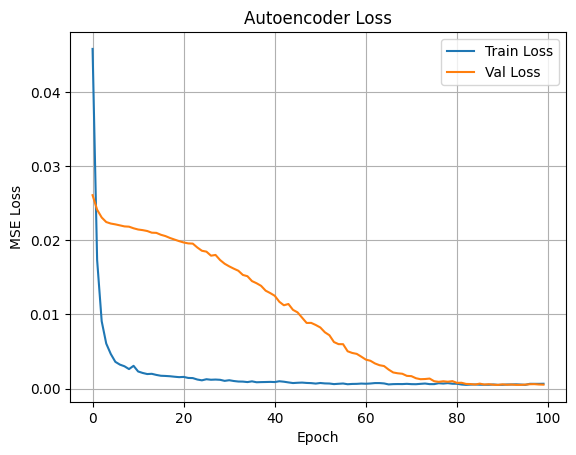

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [8]:
# Step 8: Build and train autoencoder for feature extraction
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = layers.Dense(512, activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    bottleneck = layers.Dense(128, activation='relu', name='bottleneck')(x)
    x = layers.Dense(128, activation='relu')(bottleneck)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    output = layers.Dense(input_dim, activation='sigmoid')(x)

    model = Model(input_layer, output)
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

autoencoder = build_autoencoder(X_train.shape[1])
history_ae = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, validation_data=(X_test, X_test), verbose=1)

plt.plot(history_ae.history['loss'], label='Train Loss')
plt.plot(history_ae.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.legend()
plt.show()

# Step 9: Extract bottleneck features
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
X_train_enc = encoder.predict(X_train)
X_test_enc = encoder.predict(X_test)


In [9]:
# Step 10: Build and train emotion classifier
def build_classifier(input_dim, n_classes):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

classifier = build_classifier(X_train_enc.shape[1], len(np.unique(y_encoded)))
history_clf = classifier.fit(X_train_enc, y_train, epochs=100, batch_size=32, validation_data=(X_test_enc, y_test), verbose=1)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2343 - loss: 2.7047 - val_accuracy: 0.4097 - val_loss: 1.5933
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3827 - loss: 1.9247 - val_accuracy: 0.4896 - val_loss: 1.4182
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4240 - loss: 1.6892 - val_accuracy: 0.5590 - val_loss: 1.2720
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4979 - loss: 1.4520 - val_accuracy: 0.5747 - val_loss: 1.1883
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5151 - loss: 1.3875 - val_accuracy: 0.6024 - val_loss: 1.1231
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5437 - loss: 1.3067 - val_accuracy: 0.6181 - val_loss: 1.0294
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5567 - loss: 1.2186 - val_accuracy: 0.6580 - val_loss: 0.9841
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5829 - loss: 1.1287 - val_accuracy: 0.6840 - v

In [10]:
# Step 11: Train intensity regressor
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(X_scaled, y_intensity, test_size=0.2, stratify=y_encoded, random_state=42)
X_train_enc_int = encoder.predict(X_train_int)
X_test_enc_int = encoder.predict(X_test_int)

def build_regressor(input_dim):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

regressor = build_regressor(X_train_enc_int.shape[1])
history_reg = regressor.fit(X_train_enc_int, y_train_int, epochs=100, batch_size=32, validation_data=(X_test_enc_int, y_test_int), verbose=1)

# Step 12: Make predictions
emotion_preds = classifier.predict(X_test_enc)
intensity_preds = regressor.predict(X_test_enc_int)

# Step 13: Print accuracy and predictions
from sklearn.metrics import accuracy_score

y_pred_classes = np.argmax(emotion_preds, axis=1)
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\n🎯 Accuracy: {accuracy * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 1.3710 - mae: 0.8969 - val_loss: 0.1534 - val_mae: 0.3098
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4203 - mae: 0.5134 - val_loss: 0.0934 - val_mae: 0.2548
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2862 - mae: 0.4150 - val_loss: 0.0806 - val_mae: 0.2338
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2148 - mae: 0.3646 - val_loss: 0.0794 - val_mae: 0.2292
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1756 - mae: 0.3328 - val_loss: 0.0677 - val_mae: 0.2133
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1400 - mae: 0.3003 - val_loss: 0.0765 - val_mae: 0.2168
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1152 - mae: 0.2742 - val_loss: 0.0663 - val_mae: 0.2049
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1072 - mae: 0.2617 - val_loss: 0.0609 - 


🎧 Emotion & Intensity Predictions:

▶ Emotion: Happy 🎭 | Intensity: 0.97 🔥
▶ Emotion: Fearful 🎭 | Intensity: 0.51 🔥
▶ Emotion: Calm 🎭 | Intensity: 0.37 🔥
▶ Emotion: Happy 🎭 | Intensity: 0.69 🔥
▶ Emotion: Disgust 🎭 | Intensity: 0.85 🔥
▶ Emotion: Surprised 🎭 | Intensity: 0.73 🔥
▶ Emotion: Angry 🎭 | Intensity: 0.23 🔥
▶ Emotion: Happy 🎭 | Intensity: 0.81 🔥
▶ Emotion: Happy 🎭 | Intensity: 0.83 🔥
▶ Emotion: Calm 🎭 | Intensity: 0.42 🔥


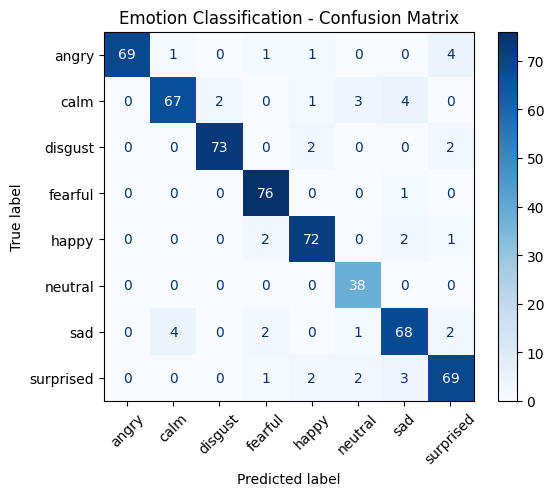

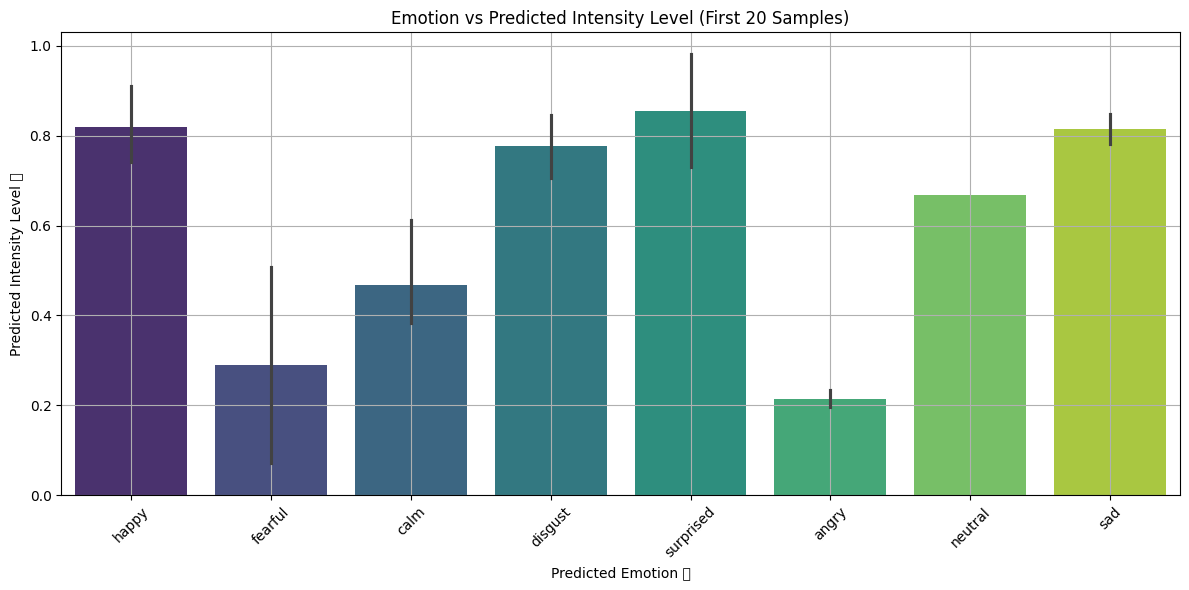


Predicted Emotion: disgust | Intensity: 0.92 🔥 | Emoji: ❓


In [11]:
# Display emotion and intensity prediction with emoji
print("\n🎧 Emotion & Intensity Predictions:\n")
for i in range(10):
    pred_label = np.argmax(emotion_preds[i])
    pred_emotion = le.inverse_transform([pred_label])[0]
    pred_intensity = np.clip(intensity_preds[i][0], 0, 1)

    print(f"▶ Emotion: {pred_emotion.title()} 🎭 | Intensity: {pred_intensity:.2f} 🔥")

# Step 14: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Emotion Classification - Confusion Matrix")
plt.grid(False)
plt.show()

# Step 15: Visualize intensity levels
plt.figure(figsize=(12, 6))
sns.barplot(x=le.inverse_transform(y_pred_classes)[:20], y=intensity_preds[:20].flatten(), palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Predicted Emotion 🎭')
plt.ylabel('Predicted Intensity Level 🔥')
plt.title('Emotion vs Predicted Intensity Level (First 20 Samples)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 16: Function to get intensity and emoji based on emotion and value
def get_intensity_and_emoji(emotion):
    intensity = round(random.uniform(0, 1), 2)  # Simulate intensity between 0 and 1

    # Emoji mapping based on emotion and intensity
    if emotion == "Happy":
        emoji = "😊" if intensity < 0.5 else "😄" if intensity < 0.8 else "😁"
    elif emotion == "Sad":
        emoji = "😔" if intensity < 0.5 else "😢" if intensity < 0.8 else "😭"
    elif emotion == "Angry":
        emoji = "😠" if intensity < 0.5 else "😡" if intensity < 0.8 else "🤬"
    elif emotion == "Surprised":
        emoji = "😯" if intensity < 0.5 else "😲" if intensity < 0.8 else "😳"
    elif emotion == "Fearful":
        emoji = "😰" if intensity < 0.5 else "😨" if intensity < 0.8 else "😱"
    elif emotion == "Disgust":
        emoji = "😒" if intensity < 0.5 else "🤢" if intensity < 0.8 else "🤮"
    elif emotion == "Calm":
        emoji = "😌" if intensity < 0.5 else "🙂" if intensity < 0.8 else "😇"
    elif emotion == "Neutral":
        emoji = "😐" if intensity < 0.5 else "😶" if intensity < 0.8 else "😑"
    else:
        emoji = "❓"

    return intensity, emoji

# Simulate a predicted emotion (you can replace this with actual prediction logic)
predicted_emotion = random.choice(list(emotion_map.values()))

# Get intensity and emoji
intensity, emoji = get_intensity_and_emoji(predicted_emotion)

print(f"\nPredicted Emotion: {predicted_emotion} | Intensity: {intensity} 🔥 | Emoji: {emoji}")

In [16]:
# Step 1: Define emoji dictionary for emotions and intensity ranges
emoji_dict = {
    "Happy":      ["😊", "😄", "😁"],
    "Sad":        ["😔", "😢", "😭"],
    "Angry":      ["😠", "😡", "🤬"],
    "Surprised":  ["😯", "😲", "😳"],
    "Fearful":    ["😰", "😨", "😱"],
    "Disgust":    ["😒", "🤢", "🤮"],
    "Calm":       ["😌", "🙂", "😇"],
    "Neutral":    ["😐", "😶", "😑"]
}

# Step 2: Function to get emoji based on intensity level
def get_emoji(emotion, intensity):
    if emotion not in emoji_dict:
        return "❓"
    if intensity < 0.5:
        return emoji_dict[emotion][0]
    elif intensity < 0.8:
        return emoji_dict[emotion][1]
    else:
        return emoji_dict[emotion][2]

# Step 3: Display predicted emotion, intensity, and emoji
print("\n🎧 Emotion & Intensity Predictions:\n")
for i in range(10):
    pred_label = np.argmax(emotion_preds[i])
    pred_emotion = le.inverse_transform([pred_label])[0].title()
    pred_intensity = float(np.clip(intensity_preds[i][0], 0, 1))

    emoji = get_emoji(pred_emotion, pred_intensity)

    print(f"▶ Emotion: {pred_emotion} 🎭 | Intensity: {pred_intensity:.2f} 🔥 | Emoji: {emoji}")



🎧 Emotion & Intensity Predictions:

▶ Emotion: Happy 🎭 | Intensity: 0.97 🔥 | Emoji: 😁
▶ Emotion: Fearful 🎭 | Intensity: 0.51 🔥 | Emoji: 😨
▶ Emotion: Calm 🎭 | Intensity: 0.37 🔥 | Emoji: 😌
▶ Emotion: Happy 🎭 | Intensity: 0.69 🔥 | Emoji: 😄
▶ Emotion: Disgust 🎭 | Intensity: 0.85 🔥 | Emoji: 🤮
▶ Emotion: Surprised 🎭 | Intensity: 0.73 🔥 | Emoji: 😲
▶ Emotion: Angry 🎭 | Intensity: 0.23 🔥 | Emoji: 😠
▶ Emotion: Happy 🎭 | Intensity: 0.81 🔥 | Emoji: 😁
▶ Emotion: Happy 🎭 | Intensity: 0.83 🔥 | Emoji: 😁
▶ Emotion: Calm 🎭 | Intensity: 0.42 🔥 | Emoji: 😌


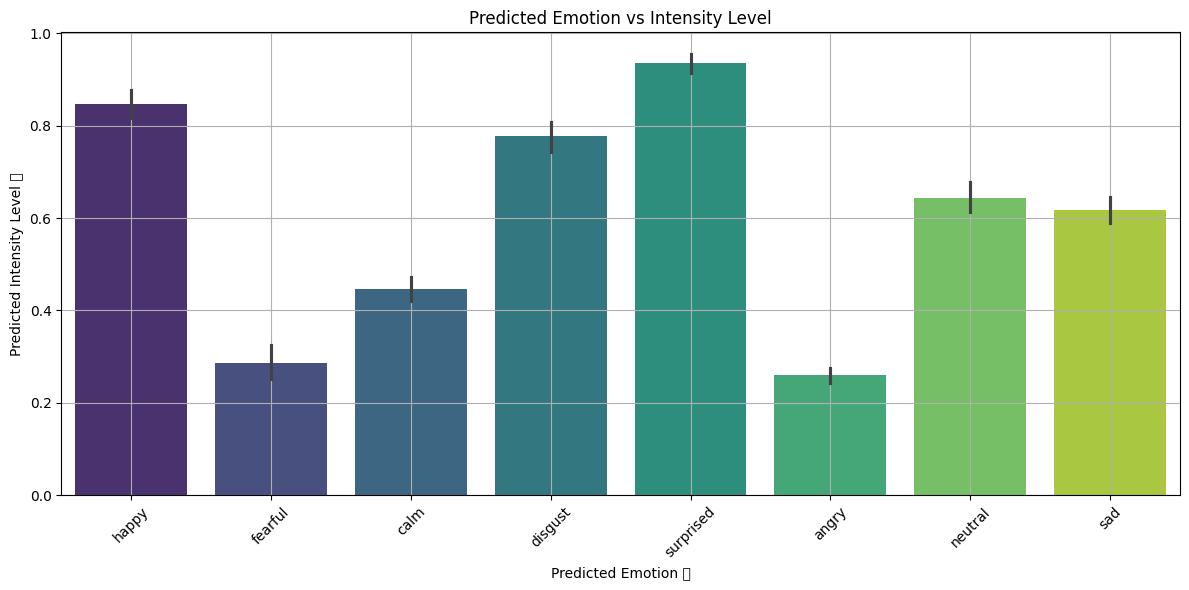

In [17]:
# Step: Visualize predicted intensity for each predicted class
plt.figure(figsize=(12, 6))
sns.barplot(x=le.inverse_transform(y_pred_classes), y=intensity_preds.flatten(), palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Predicted Emotion 🎭')
plt.ylabel('Predicted Intensity Level 🔥')
plt.title('Predicted Emotion vs Intensity Level')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Step 18: Evaluation Metrics and Print Accuracy
from sklearn.metrics import classification_report, accuracy_score

# Get the classification report for detailed evaluation metrics
report = classification_report(y_test, y_pred_classes, target_names=le.classes_)
print("🎯 Classification Report:\n", report)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"🎯 Accuracy: {accuracy * 100:.2f}%")

🎯 Classification Report:
               precision    recall  f1-score   support

       angry       1.00      0.91      0.95        76
        calm       0.93      0.87      0.90        77
     disgust       0.97      0.95      0.96        77
     fearful       0.93      0.99      0.96        77
       happy       0.92      0.94      0.93        77
     neutral       0.86      1.00      0.93        38
         sad       0.87      0.88      0.88        77
   surprised       0.88      0.90      0.89        77

    accuracy                           0.92       576
   macro avg       0.92      0.93      0.92       576
weighted avg       0.93      0.92      0.92       576

🎯 Accuracy: 92.36%
